# Workflow for models training



## Libraries and read in cleaned data

Data cleaning (done by Yvonne) and following steps were taken:
- removing rows with nan in RT
- removing rows with nan in concentration
- removing calibration graphs with only 1 or 2 calibration points

Data set contains 3860 rows and no nan values


In [42]:
# libraries
import pandas as pd
import numpy as np
from plotnine import *

# data
file_path = "C:/Users/HelenSepman/OneDrive - Kruvelab/Documents/GitHub/ML_calibration_graph_linearity/0_data/data_ready_addfeatures_231128.csv"
# file_path = "C:/Users/yvkr1259/Documents/data_ready_addfeatures_231122.csv"

df_calibrations = pd.read_csv(file_path)
# remove all the normaized columns 
drop_columns = ['abs_residuals_norm1', 'abs_residuals_norm2','c_real_M_norm1','c_real_M_norm2','peak_area_norm1',
'peak_area_norm2','residuals_norm1','residuals_norm2','rf_error_norm1','rf_error_norm2','rf_norm1','rf_norm2']

df_calibrations = df_calibrations.drop(drop_columns, axis=1)
df_calibrations.info()

## load data to google colab
#from google.colab import files
#uploaded = files.upload()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3850 entries, 0 to 3849
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lab            3850 non-null   object 
 1   compound       3850 non-null   object 
 2   sample_type    3850 non-null   object 
 3   RT             3850 non-null   float64
 4   sample         3850 non-null   object 
 5   peak_area      3850 non-null   float64
 6   note           3850 non-null   object 
 7   c_real_M       3850 non-null   float64
 8   rf             3850 non-null   float64
 9   rf_error       3850 non-null   float64
 10  slope          3850 non-null   float64
 11  intercept      3850 non-null   float64
 12  residuals      3850 non-null   float64
 13  abs_residuals  3850 non-null   float64
dtypes: float64(9), object(5)
memory usage: 421.2+ KB


In [43]:
#file_path = "data_ready_addfeatures_231122.csv"
#df_calibrations = pd.read_csv(file_path)
#df_calibrations.info()

## Select features and data splitting

Data splitting should consider that points for each compound per lab belong together. Therefore an individual id for each compound lab pair is introduced. Splitting is then performed based on the id

In [44]:
df_calibrations['id'] = df_calibrations['lab'] + '_' + df_calibrations['compound']

In [45]:
import sklearn
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set based on id 
unique_ids = df_calibrations['id'].unique()
np.random.seed(123)
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42) # 80% training and 20% test


df_train = df_calibrations[df_calibrations['id'].isin(train_ids)]
df_test = df_calibrations[df_calibrations['id'].isin(test_ids)]

# Split dataset into features and target variable
X_train =  df_train.drop('note', axis=1)
y_train = df_train[['note']]
X_test = df_test.drop('note', axis=1)
y_test = df_test[['note']]


print(X_train.shape) 
print(y_train.shape) 
print(X_test.shape) 
print(y_test.shape) 

# (3093, 14)
# (3093, 1)
# (767, 14)
# (767, 1)


(3084, 14)
(3084, 1)
(766, 14)
(766, 1)


In [46]:
## Calculate Response factors to a previous point

corresponding_values = pd.DataFrame()

# Loop over unique lab and compound combinations
for lab in X_train['lab'].unique():
    for compound_here in X_train[X_train['lab'] == lab]['compound'].unique():
        # Order the DataFrame based on 'c_real_M' in ascending order
        compound_subset = X_train[(X_train['lab'] == lab) & (X_train['compound'] == compound_here)].sort_values('c_real_M')

        # Initialize starting points
        starting_point_x = 0
        starting_point_y = 0

        # Loop over rows in the compound subset
        for index, row in compound_subset.iterrows():
            # Calculate differences
            difference_y = row['peak_area'] - starting_point_y
            difference_x = row['c_real_M'] - starting_point_x

            # Add 'c_real_M', 'peak_area', and other info from the compound_subset
            # Also, add difference_y/difference_x to the DataFrame
            corresponding_values = corresponding_values.append({
                'lab': lab,
                'compound': compound_here,
                'c_real_M': row['c_real_M'],
                'peak_area': row['peak_area'],
                # 'other_info': row['other_info'],  # Comment out or remove this line
                'difference_y': difference_y,
                'difference_x': difference_x,
                'difference_y_divided_by_x': difference_y / difference_x  # Add this line
            }, ignore_index=True)


            # Update starting points for the next iteration
            starting_point_x = row['c_real_M']
            starting_point_y = row['peak_area']

X_train = pd.merge(X_train, corresponding_values, on=['lab', 'compound', 'c_real_M', 'peak_area'], how='left')


C:\Users\HelenSepman\AppData\Local\Temp\ipykernel_16520\4252580202.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\HelenSepman\AppData\Local\Temp\ipykernel_16520\4252580202.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\HelenSepman\AppData\Local\Temp\ipykernel_16520\4252580202.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\HelenSepman\AppData\Local\Temp\ipykernel_16520\4252580202.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\HelenSepman\AppData\Local\Temp\ipykernel_16520\4252580202.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

In [47]:
corresponding_values = pd.DataFrame()

# Loop over unique lab and compound combinations
for lab in X_test['lab'].unique():
    for compound_here in X_test[X_test['lab'] == lab]['compound'].unique():
        # Order the DataFrame based on 'c_real_M' in ascending order
        compound_subset = X_test[(X_test['lab'] == lab) & (X_test['compound'] == compound_here)].sort_values('c_real_M')

        # Initialize starting points
        starting_point_x = 0
        starting_point_y = 0

        # Loop over rows in the compound subset
        for index, row in compound_subset.iterrows():
            # Calculate differences
            difference_y = row['peak_area'] - starting_point_y
            difference_x = row['c_real_M'] - starting_point_x

            # Add 'c_real_M', 'peak_area', and other info from the compound_subset
            # Also, add difference_y/difference_x to the DataFrame
            corresponding_values = corresponding_values.append({
                'lab': lab,
                'compound': compound_here,
                'c_real_M': row['c_real_M'],
                'peak_area': row['peak_area'],
                # 'other_info': row['other_info'],  # Comment out or remove this line
                'difference_y': difference_y,
                'difference_x': difference_x,
                'difference_y_divided_by_x': difference_y / difference_x  # Add this line
            }, ignore_index=True)


            # Update starting points for the next iteration
            starting_point_x = row['c_real_M']
            starting_point_y = row['peak_area']

# Display the resulting DataFrame
#print(corresponding_values)

X_test = pd.merge(X_test, corresponding_values, on=['lab', 'compound', 'c_real_M', 'peak_area'], how='left')

C:\Users\HelenSepman\AppData\Local\Temp\ipykernel_16520\1914238253.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\HelenSepman\AppData\Local\Temp\ipykernel_16520\1914238253.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\HelenSepman\AppData\Local\Temp\ipykernel_16520\1914238253.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\HelenSepman\AppData\Local\Temp\ipykernel_16520\1914238253.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\HelenSepman\AppData\Local\Temp\ipykernel_16520\1914238253.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

### Normalization

In general we decided to try out two different normalisation strategies:

**norm1**
$$
\text{norm1} = \frac{\text{x}}{\max(\text{x})}
$$

**norm2**
$$
\text{norm2} = \frac{\text{x} - \min(\text{x})}{\max(\text{x}) - \min(\text{x})}
$$

#### normalization strategy 1

In [48]:
# train set 
X_train['peak_area_norm1'] = X_train.groupby(['lab', 'compound'])['peak_area'].transform(lambda x: x / x.max())
X_train['c_real_M_norm1'] = X_train.groupby(['lab', 'compound'])['c_real_M'].transform(lambda x: x / x.max())
X_train['rf_norm1'] = X_train.groupby(['lab', 'compound'])['rf'].transform(lambda x: x / x.max())
X_train['rf_error_norm1'] = X_train.groupby(['lab', 'compound'])['rf_error'].transform(lambda x: x / x.max())
X_train['residuals_norm1'] = X_train.groupby(['lab', 'compound'])['residuals'].transform(lambda x: x / x.max())
X_train['abs_residuals_norm1'] = X_train.groupby(['lab', 'compound'])['abs_residuals'].transform(lambda x: x / x.max())
X_train['difference_y_norm1'] = X_train.groupby(['lab', 'compound'])['difference_y'].transform(lambda x: x / x.max())
X_train['difference_x_norm1'] = X_train.groupby(['lab', 'compound'])['difference_x'].transform(lambda x: x / x.max())
X_train['difference_y_divided_by_x_norm1'] = X_train.groupby(['lab', 'compound'])['difference_y_divided_by_x'].transform(lambda x: x / x.max())

# test set 
X_test['peak_area_norm1'] = X_test.groupby(['lab', 'compound'])['peak_area'].transform(lambda x: x / x.max())
X_test['c_real_M_norm1'] = X_test.groupby(['lab', 'compound'])['c_real_M'].transform(lambda x: x / x.max())
X_test['rf_norm1'] = X_test.groupby(['lab', 'compound'])['rf'].transform(lambda x: x / x.max())
X_test['rf_error_norm1'] = X_test.groupby(['lab', 'compound'])['rf_error'].transform(lambda x: x / x.max())
X_test['residuals_norm1'] = X_test.groupby(['lab', 'compound'])['residuals'].transform(lambda x: x / x.max())
X_test['abs_residuals_norm1'] = X_test.groupby(['lab', 'compound'])['abs_residuals'].transform(lambda x: x / x.max())
X_test['difference_y_norm1'] = X_test.groupby(['lab', 'compound'])['difference_y'].transform(lambda x: x / x.max())
X_test['difference_x_norm1'] = X_test.groupby(['lab', 'compound'])['difference_x'].transform(lambda x: x / x.max())
X_test['difference_y_divided_by_x_norm1'] = X_test.groupby(['lab', 'compound'])['difference_y_divided_by_x'].transform(lambda x: x / x.max())


#### normalization strategy 2

In [49]:
from sklearn.preprocessing import MinMaxScaler

columns_to_scale = ['peak_area', 'c_real_M', 'rf', 'rf_error', 'residuals', 'abs_residuals']

scaler = MinMaxScaler()

def scale_columns(group):
    for col in columns_to_scale:
        group[f'{col}_norm2'] = scaler.fit_transform(group[[col]])
    return group


X_train = X_train.groupby(['lab', 'compound'], group_keys = False).apply(scale_columns) # group_keys = False to not include group keys in the resulting df
X_test = X_test.groupby(['lab', 'compound'], group_keys = False).apply(scale_columns)

In [50]:
## Decide on features for modelling
#features = ['peak_area','c_real_M']
#features = ['RT','peak_area','c_real_M']
#features = ['RT','peak_area','c_real_M', 'rf', 'rf_error']
#features = ['RT','peak_area','c_real_M', 'rf', 'rf_error', 'slope', 'intercept', 'residuals', 'abs_residuals']
#features = ['RT','peak_area_norm1','c_real_M_norm1', 'rf_norm1', 'rf_error_norm1', 'slope', 'intercept', 'residuals_norm1', 'abs_residuals_norm1'] # best features
features = ['c_real_M_norm1','difference_y_norm1', 'difference_x_norm1', 'difference_y_divided_by_x_norm1', 'rf_norm1', 'rf_error_norm1', 'slope', 'intercept', 'residuals_norm1', 'abs_residuals_norm1'] # best features
#eatures = ['RT','peak_area_norm2','c_real_M_norm2', 'rf_norm2', 'rf_error_norm2', 'slope', 'intercept', 'residuals_norm2', 'abs_residuals_norm2']

In [51]:
X_train_sel = X_train[features]
X_test_sel = X_test[features]

In [52]:
# Converting labels to 0 (linear) and 1 (non-linear) 
y_train = y_train.replace({'linear': 1, 'non-linear': 0})
y_test = y_test.replace({'linear': 1, 'non-linear': 0})

## Modeling 

In [53]:
# Libraries

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
import scikitplot as skplt
import matplotlib.pyplot as plt

In [54]:
# Convert the labels (y_train and y_test) into 1D arrays
y_train_1D = y_train.values.ravel()
y_test_1D = y_test.values.ravel()

### Random Forest

#### NB! No need to rerun the cell below unless you want to check the parameter search or make changes!

In [32]:
'''
# Hyperparameter search
param_distributions = {
    'n_estimators': [50, 100, 300, 500],
    'max_depth': [None, 10, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

# Initialize the base model
rf = RandomForestClassifier(random_state = 1)

# Set up the RandomizedSearchCV object
rf_random_search = RandomizedSearchCV(
    estimator = rf,
    param_distributions = param_distributions,
    n_iter = 100,
    cv = 5, 
    verbose = 2,
    random_state = 1,
    n_jobs = -1 # uses all cores!!
)

# Fit the RandomizedSearchCV object to the training data
rf_random_search.fit(X_train_sel, y_train_1D)

# Print the best hyperparameters
print("Best Hyperparameters:\n", rf_random_search.best_params_)
'''

'\n# Hyperparameter search\nparam_distributions = {\n    \'n_estimators\': [50, 100, 300, 500],\n    \'max_depth\': [None, 10, 30, 50],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4],\n    \'bootstrap\': [True, False],\n    \'max_features\': [\'sqrt\', \'log2\'],\n    \'criterion\': [\'gini\', \'entropy\']\n}\n\n# Initialize the base model\nrf = RandomForestClassifier(random_state = 1)\n\n# Set up the RandomizedSearchCV object\nrf_random_search = RandomizedSearchCV(\n    estimator = rf,\n    param_distributions = param_distributions,\n    n_iter = 100,\n    cv = 5, \n    verbose = 2,\n    random_state = 1,\n    n_jobs = -1 # uses all cores!!\n)\n\n# Fit the RandomizedSearchCV object to the training data\nrf_random_search.fit(X_train_sel, y_train_1D)\n\n# Print the best hyperparameters\nprint("Best Hyperparameters:\n", rf_random_search.best_params_)\n'

Best Hyperparameters RF: </br>
{'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': True}

In [55]:
# Set up RF model using the optimal hyperparameters
best_rf = RandomForestClassifier(random_state = 1,
                                 n_estimators = 50,
                                 min_samples_split = 10,
                                 min_samples_leaf = 4,
                                 max_features = 'log2',
                                 max_depth = 10,
                                 criterion = 'entropy',
                                 bootstrap = True)

# Fit the model with the best hyperparameters on the full oversampled training data
best_rf.fit(X_train_sel, y_train_1D)

# Predicting probabilities on the validation set for AUC calculation
prob_predictions_rf = best_rf.predict_proba(X_test_sel)[:, 1]

# Calculate AUC
auc_score = roc_auc_score(y_test_1D, prob_predictions_rf)
print(f"AUC Score: {auc_score:.2%}")

# Predicting class labels (for accuracy, confusion matrix, etc.)
class_predictions_rf = best_rf.predict(X_test_sel)

# Evaluating the model on the validation set
test_accuracy_rf = accuracy_score(y_test_1D, class_predictions_rf)
print(f"Accuracy Testset: {test_accuracy_rf:.2%}")

# Detailed classification report
print("Classification Report:\n", classification_report(y_test_1D, class_predictions_rf))

# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test_1D, class_predictions_rf)
print("Confusion Matrix:\n", conf_matrix_rf)

AUC Score: 91.09%
Accuracy Testset: 82.25%
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.77      0.80       342
           1       0.83      0.86      0.84       424

    accuracy                           0.82       766
   macro avg       0.82      0.82      0.82       766
weighted avg       0.82      0.82      0.82       766

Confusion Matrix:
 [[265  77]
 [ 59 365]]


In [56]:
## Adding the real and predicted labels to testset

# Convert the actual and predicted labels to pandas Series (for compatibility)
actual_labels = pd.Series(y_test_1D, name='actual_labels')
predicted_labels = pd.Series(class_predictions_rf, name='predicted_labels')
pred_labels_prob = pd.Series(prob_predictions_rf, name='pred_labels_prob')

# Reset the index of X_test to allow for a clean concatenation
X_test_reset = X_test.reset_index(drop=True)

# Concatenate the features with the actual and predicted labels
RF_test_set = pd.concat([X_test_reset, actual_labels, predicted_labels, pred_labels_prob], axis=1)

# Display the first few rows of the new DataFrame
print(RF_test_set.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766 entries, 0 to 765
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   lab                              766 non-null    object 
 1   compound                         766 non-null    object 
 2   sample_type                      766 non-null    object 
 3   RT                               766 non-null    float64
 4   sample                           766 non-null    object 
 5   peak_area                        766 non-null    float64
 6   c_real_M                         766 non-null    float64
 7   rf                               766 non-null    float64
 8   rf_error                         766 non-null    float64
 9   slope                            766 non-null    float64
 10  intercept                        766 non-null    float64
 11  residuals                        766 non-null    float64
 12  abs_residuals         

#### Calculate the slope for linear points based on expert labels (slope_expert) and predicted labels (pred_slope) for each compound and lab

In [57]:
from sklearn.linear_model import LinearRegression

def calculate_slope(group, label_column):
    # Filter out only the linear points
    linear_points = group[group[label_column] == 1]

    # Check if there are enough points to fit a line
    if len(linear_points) >= 3:
        # Fit linear regression
        model = LinearRegression()
        # Assuming 'feature1' and 'feature2' are the features to be used for regression
        model.fit(linear_points[['c_real_M']], linear_points['peak_area'])
        # Return the slope
        return model.coef_[0]
    else:
        # Return NaN or some default value if not enough points
        return float('nan')

def calculate_slope_weighted(group, label_column):
    # Filter out only the linear points
    linear_points = group[group[label_column] > -1]

    # Check if there are enough points to fit a line
    if len(linear_points) >= 3:
        # Fit linear regression
        model = LinearRegression()
        # Assuming 'feature1' and 'feature2' are the features to be used for regression
        model.fit(linear_points[['c_real_M']], linear_points['peak_area'], (1-linear_points['pred_labels_prob']))
        # Return the slope
        return model.coef_[0]
    else:
        # Return NaN or some default value if not enough points
        return float('nan')

# Group by 'lab' and 'compound', then apply the calculate_slope function
slope_expert = RF_test_set.groupby(['lab', 'compound']).apply(calculate_slope, label_column='actual_labels')
pred_slope = RF_test_set.groupby(['lab', 'compound']).apply(calculate_slope, label_column='predicted_labels')
pred_slope_weighted = RF_test_set.groupby(['lab', 'compound']).apply(calculate_slope_weighted, label_column='predicted_labels')

# Convert to dataframes
slope_expert_df = slope_expert.reset_index().rename(columns={0: 'slope_expert'})
pred_slope_df = pred_slope.reset_index().rename(columns={0: 'pred_slope'})
pred_slope_weighted_df = pred_slope_weighted.reset_index().rename(columns={0: 'pred_slope_weighted'})
## Add slopes back to RF_test_set df
# Merge slope_expert
RF_test_set = RF_test_set.merge(slope_expert_df, on=['lab', 'compound'], how='left')

# Merge pred_slope
RF_test_set = RF_test_set.merge(pred_slope_df, on=['lab', 'compound'], how='left')

# Merge pred_slope
RF_test_set = RF_test_set.merge(pred_slope_weighted_df, on=['lab', 'compound'], how='left')

In [58]:
RF_test_set.head()

lab  compound sample_type    RT sample     peak_area      c_real_M  \
0  L1  Atrazine         cal  4.92   cal1  1.488900e+09  1.930000e-06   
1  L1  Atrazine         cal  4.92   cal2  4.773961e+08  8.290000e-07   
2  L1  Atrazine         cal  4.92   cal3  3.141558e+08  4.240000e-07   
3  L1  Atrazine         cal  4.92   cal4  1.646883e+08  2.480000e-07   
4  L1  Atrazine         cal  4.92   cal5  6.933636e+07  8.510000e-08   

             rf      rf_error         slope  ...  rf_norm2  rf_error_norm2  \
0  7.714507e+14  7.202735e+13  7.602001e+14  ...  0.818695        0.415775   
1  5.758698e+14  1.235535e+14  7.602001e+14  ...  0.000000        1.000000   
2  7.409334e+14  4.151011e+13  7.602001e+14  ...  0.690951        0.069758   
3  6.640656e+14  3.535771e+13  7.602001e+14  ...  0.369185        0.000000   
4  8.147633e+14  1.153400e+14  7.602001e+14  ...  1.000000        0.906872   

   residuals_norm2 abs_residuals_norm2  actual_labels  predicted_labels  \
0         1.000000            0.369017              1                 1   
1         0.000000            1.000000              0                 1   
2         0.828776            0.126953              1                 1   
3         0.738975            0.000000              1                 1   
4         0.902189            0.230739              1                 1   

   pred_labels_prob  slope_expert    pred_slope  pred_slope_weighted  
0          0.794834  7.747159e+14  7.602001e+14         7.962527e+14  
1          0.515095  7.747159e+14  7.602001e+14         7.962527e+14  
2          0.944181  7.747159e+14  7.602001e+14         7.962527e+14  
3          0.987499  7.747159e+14  7.602001e+14         7.962527e+14  
4          0.973949  7.747159e+14  7.602001e+14         7.962527e+14  

[5 rows x 38 columns]

Visualizing incorrect predictions

In [59]:
RF_test_set['pred_summary'] = [
    actual + predicted if actual == predicted else actual - predicted
    for actual, predicted in zip(RF_test_set['actual_labels'], RF_test_set['predicted_labels'])
]

In [60]:
RF_test_subset = RF_test_set #RF_test_set[RF_test_set['lab']=='L1']

c:\anaconda3\Lib\site-packages\plotnine\stats\stat_smooth.py:210: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthetic has the right dtype.
c:\anaconda3\Lib\site-packages\plotnine\stats\stat_smooth.py:210: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthetic has the right dtype.
c:\anaconda3\Lib\site-packages\plotnine\stats\stat_smooth.py:210: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthetic has the right dtype.
c:\anaconda3\Lib\site-packages\plotnine\stats\stat_smooth.py:210: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthet

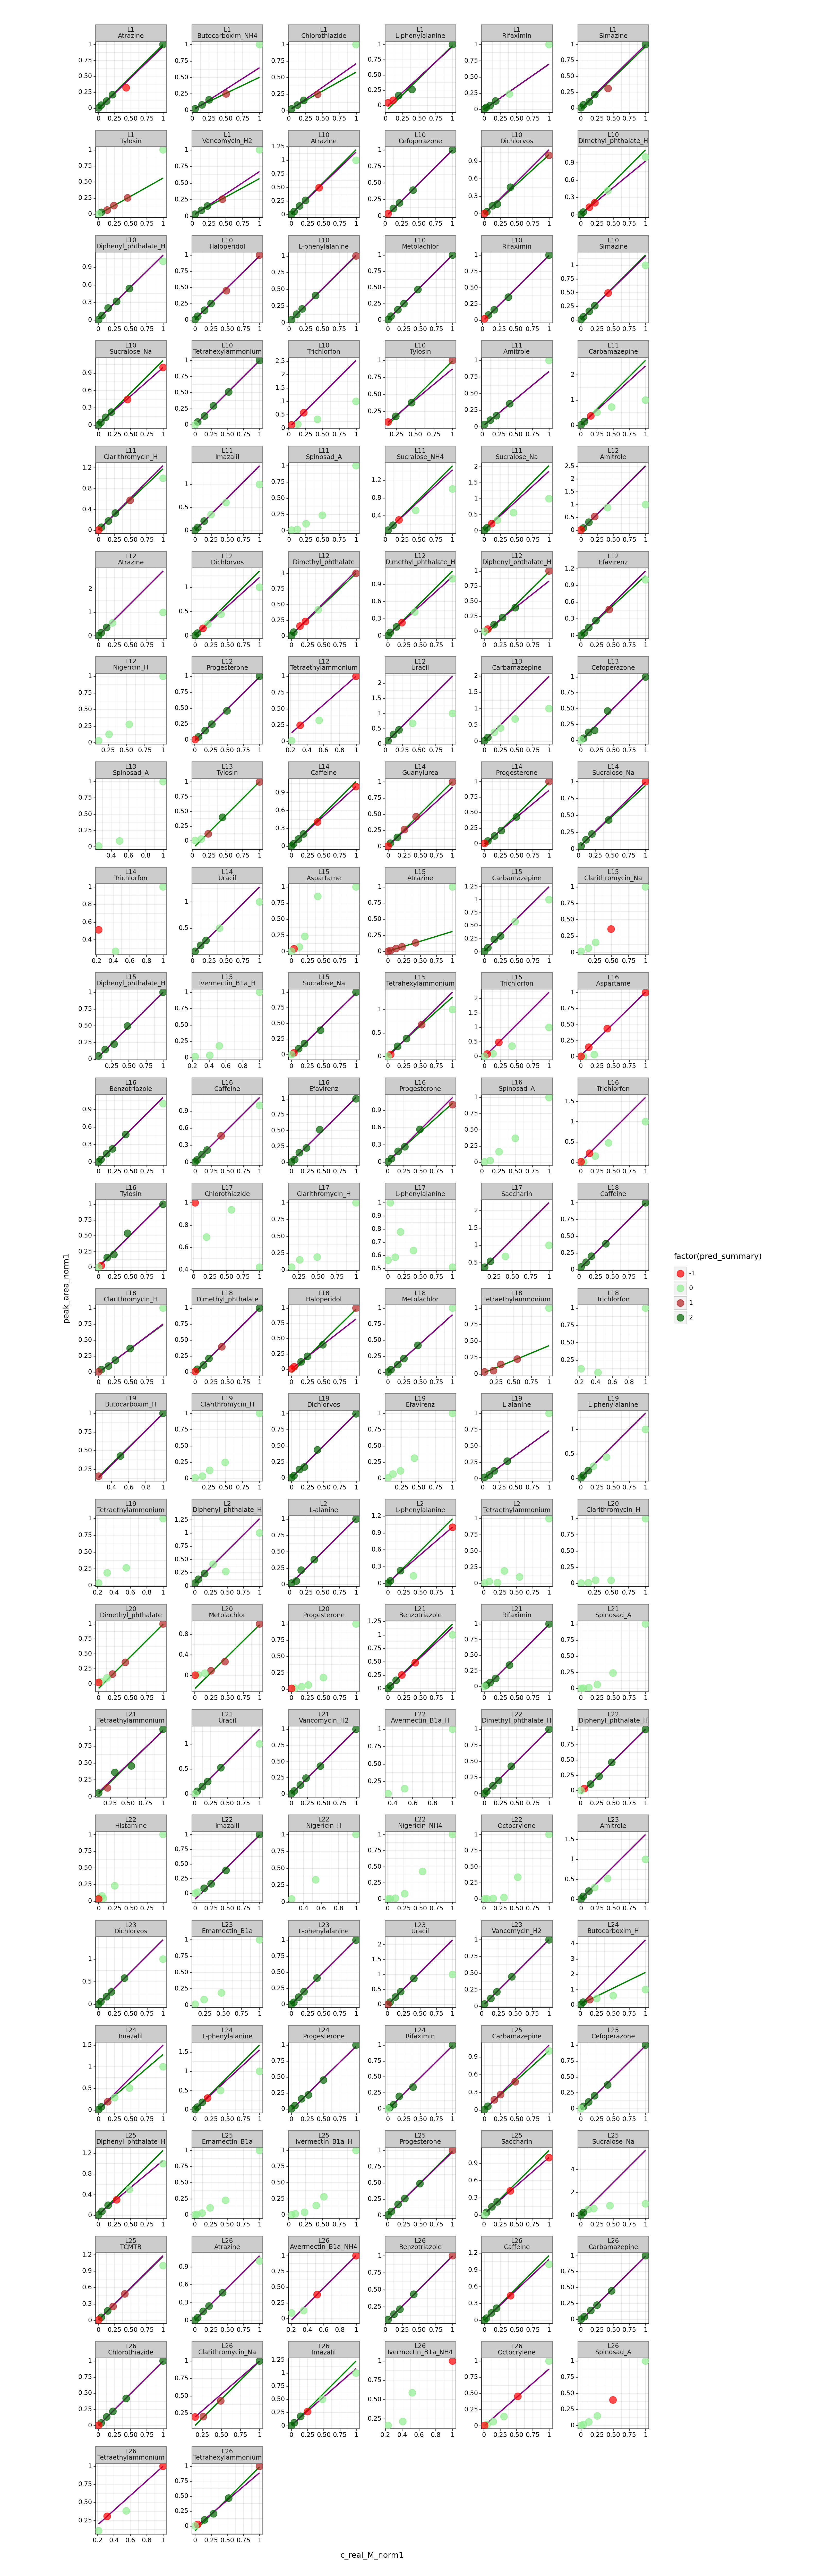

<Figure Size: (1600 x 5000)>

In [61]:

# Plotting, if needed
fig = (
    ggplot(data = RF_test_subset,
          mapping = aes(x = 'c_real_M_norm1', y = 'peak_area_norm1')) +
    geom_smooth(data=RF_test_subset[RF_test_subset['actual_labels'] == 1], method='lm', formula='y ~ x', se=False, color = "green", fullrange=True) + 
    geom_smooth(data=RF_test_subset[RF_test_subset['predicted_labels'] == 1], method='lm', formula='y ~ x', se=False, color = "purple", fullrange=True) + 
    geom_point(aes(color = "factor(pred_summary)"), size=5, alpha = 0.7) +   
    scale_color_manual(values=("red", "lightgreen", "firebrick", "darkgreen")) +
    theme_bw() +
    #scale_y_log10() +
    #scale_x_log10() + 
    facet_wrap("~ lab + compound",
            ncol=6,
            scales="free") +

    theme(figure_size = (16, 50),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'),
          aspect_ratio=1
          ) 
)
fig


RED - pred as linear but is not

DARKRED - pred as non-linear but is linear

LIGHTGREEN pred as non-linear is non-linear

DARKGREEN pred as linear is linear

c:\anaconda3\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 56 rows containing missing values.


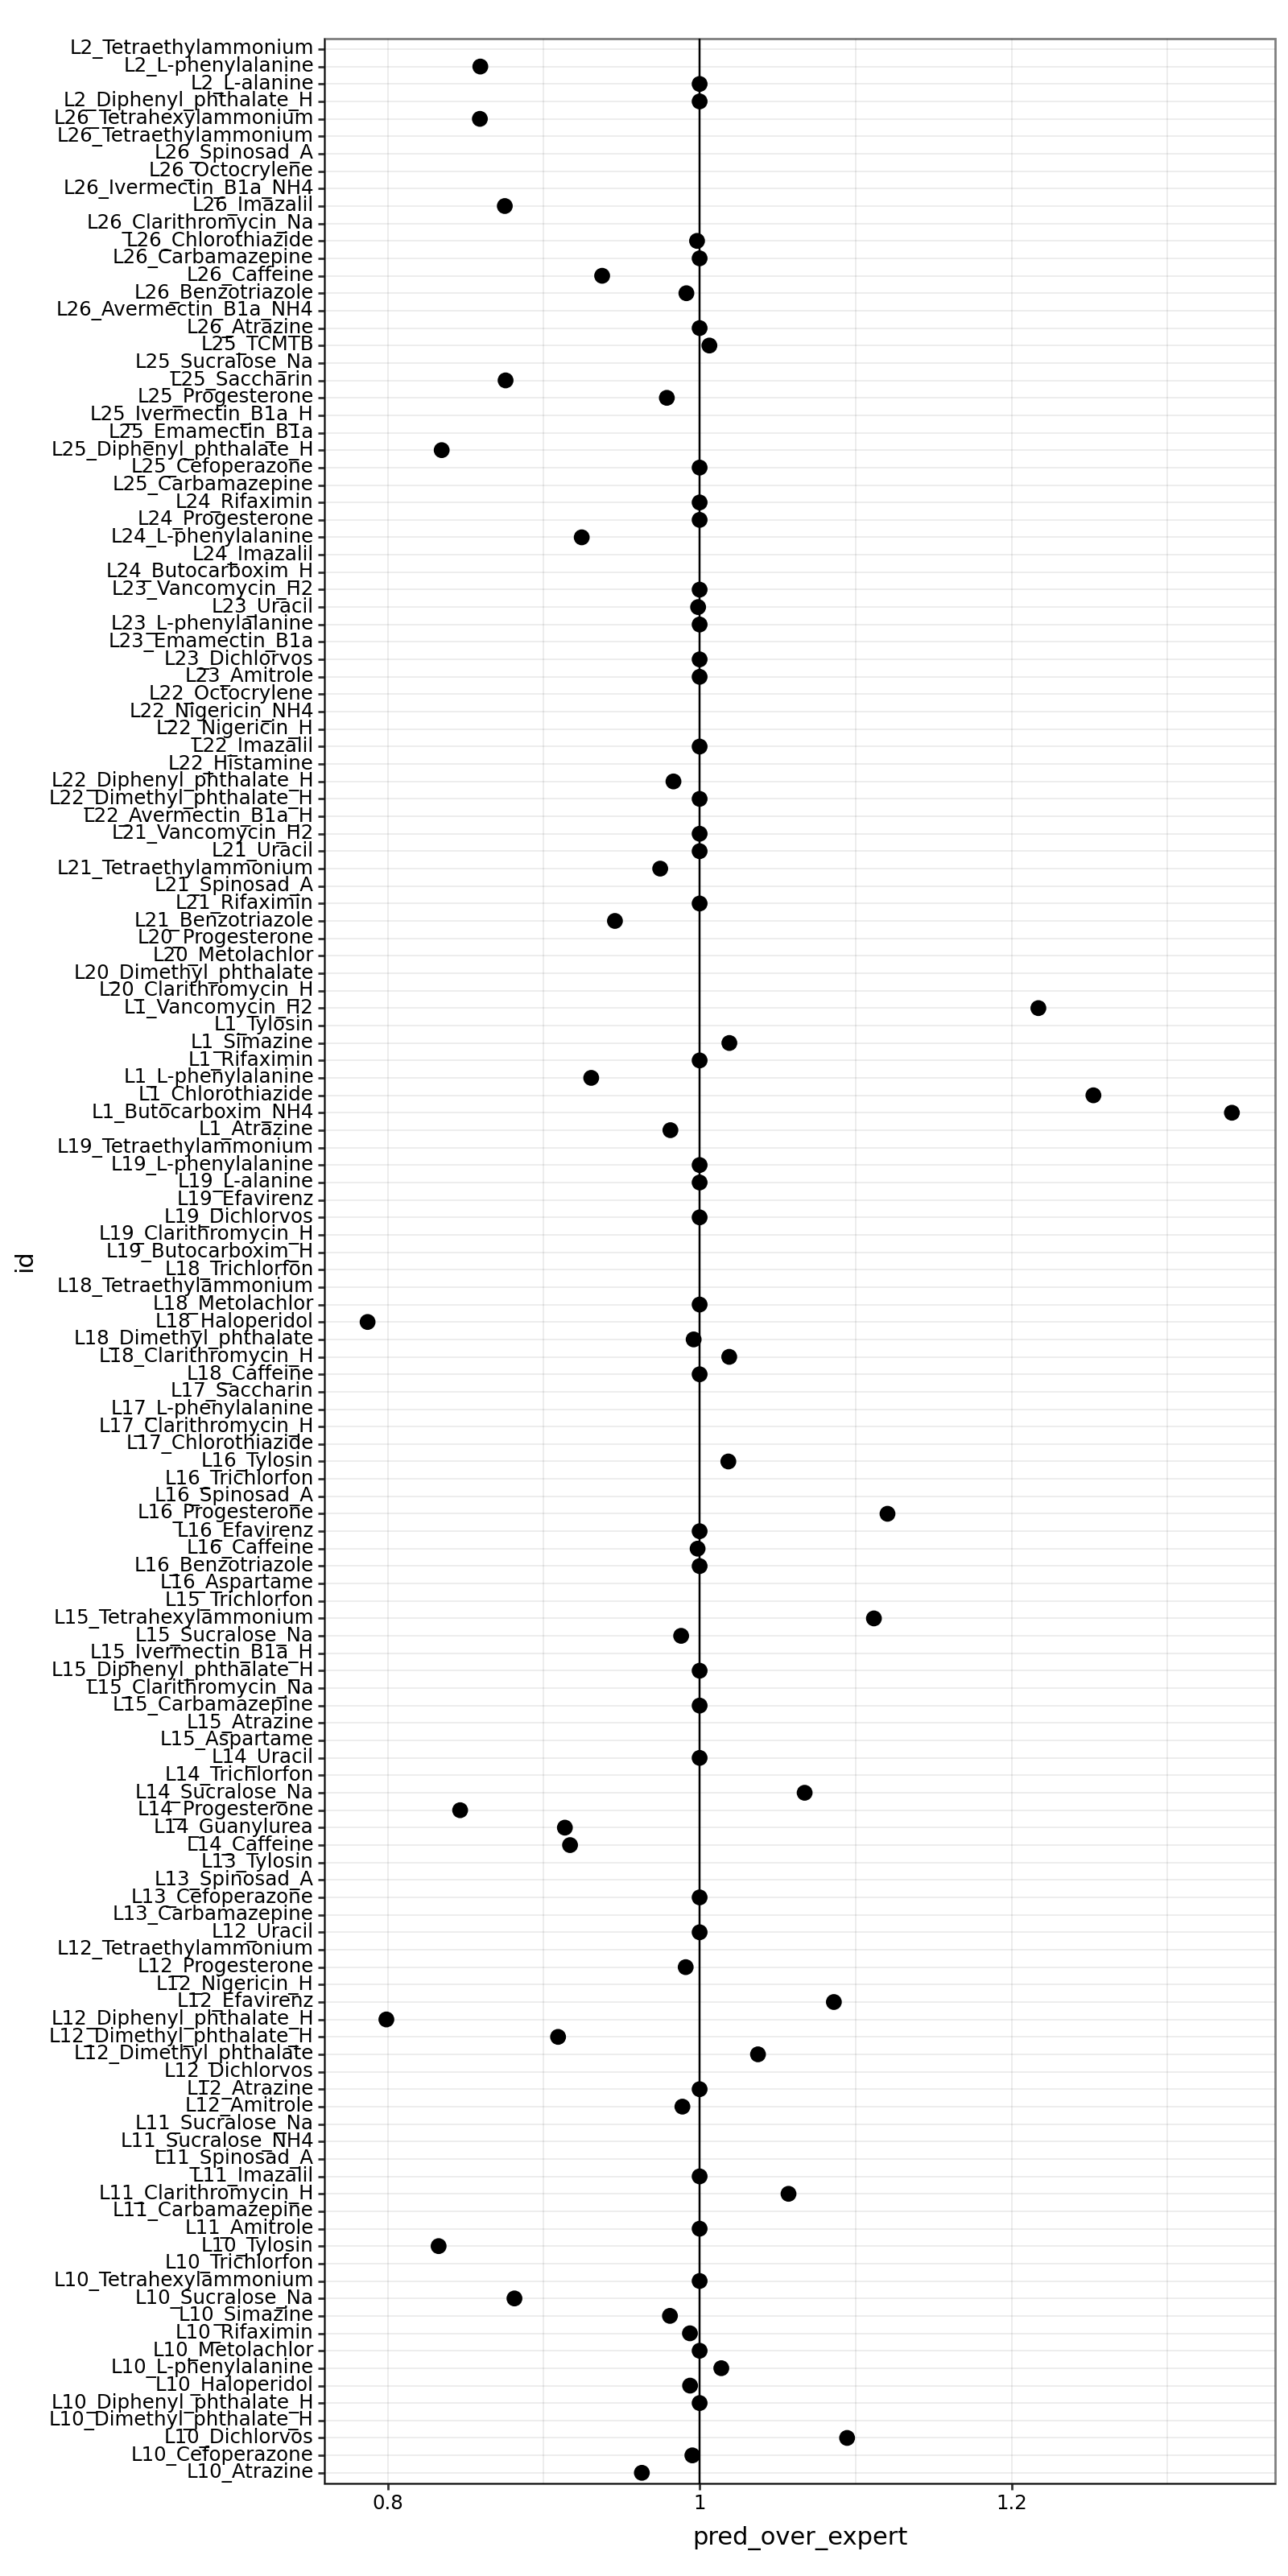

<Figure Size: (800 x 1600)>

In [62]:
#slope real /slope pred

slope_comparisons = RF_test_set
slope_comparisons['pred_over_expert'] = slope_comparisons['pred_slope'] / slope_comparisons['slope_expert']


selected_columns = ['id', 'pred_over_expert']

# Select only the specified columns
selected_df = slope_comparisons[selected_columns].drop_duplicates()

fig = (
    ggplot(data = selected_df,
          mapping = aes(x = 'id', y = 'pred_over_expert')) +
    geom_point(size=3) +   
    geom_abline(intercept = 1, slope = 0) +
    #scale_color_manual(values=("firebrick", "darkgreen","red", "lightgreen")) +
    theme_bw() +
    coord_flip() +
    #scale_y_log10() +
    #scale_x_log10() + 

    theme(figure_size = (8, 16),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black')
          ) 
)
fig


c:\anaconda3\Lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_bin : Removed 56 rows containing non-finite values.


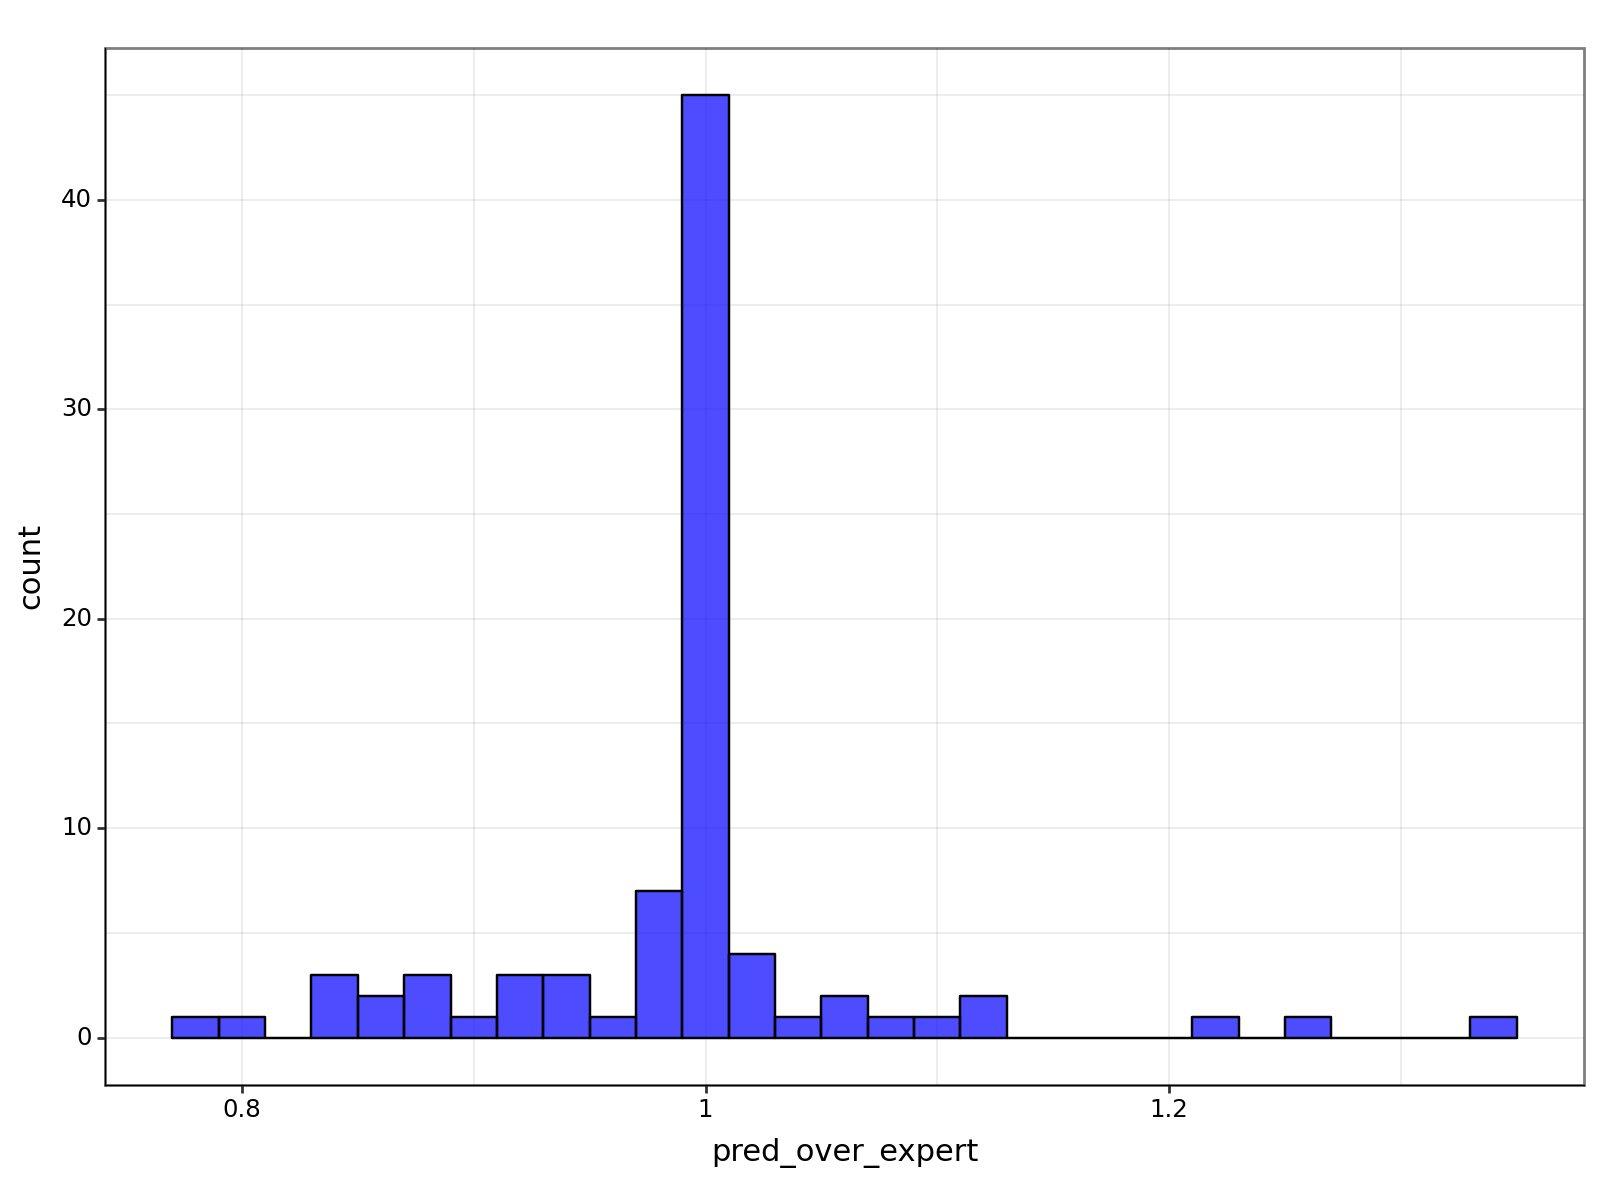

<Figure Size: (800 x 600)>

In [64]:
# histogram
fig = (
    ggplot(data = selected_df) +
    geom_histogram(mapping = aes(x = 'pred_over_expert'), binwidth=0.02, fill='blue', color='black', alpha=0.7)  +
    
    theme_bw() +
    #scale_y_log10() +
    #scale_x_log10() + 

    theme(figure_size = (8, 6),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black')
          ) 
)
fig

In [65]:
# Get feature importances
importances = best_rf.feature_importances_

# Assuming X_train is a DataFrame with column names
feature_names = X_train_sel.columns

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

# Display the feature importances
print(feature_importances_df)

                           feature  importance
4                         rf_norm1    0.226804
3  difference_y_divided_by_x_norm1    0.152382
1               difference_y_norm1    0.124834
2               difference_x_norm1    0.091857
0                   c_real_M_norm1    0.087616
5                   rf_error_norm1    0.075869
7                        intercept    0.075335
8                  residuals_norm1    0.068689
9              abs_residuals_norm1    0.049512
6                            slope    0.047102


### XGBoost


#### No need to rerun code block below

In [31]:
'''
# Define the hyperparameter grid to search for best settings
param_grid = {
    'max_depth': [3, 6, 10],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Initialize the XGBClassifier
xgb = XGBClassifier(random_state = 1, use_label_encoder = False, eval_metric = 'logloss')

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator = xgb,
    param_distributions = param_grid,
    n_iter = 100, 
    scoring = 'roc_auc', 
    cv = 5,
    verbose = 2,
    random_state = 1,
    n_jobs = -1  # Use all available cores
)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train_sel, y_train_1D)

# Print the best parameters
print("Best parameters:\n", random_search.best_params_)
'''

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters:
 {'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 10, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 1.0}


Best parameters XGBoost: </br>
 {'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 10, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 1.0}

In [66]:
# Set up XGBoost model using the optimal hyperparameters
best_xgb = XGBClassifier(random_state = 1,
                         use_label_encoder = False,
                         eval_metric = 'logloss',
                         subsample = 0.7,
                         n_estimators = 500,
                         min_child_weight = 10,
                         max_depth = 6,
                         learning_rate = 0.01,
                         colsample_bytree = 1.0)

# Train the best estimator on the full training data
best_xgb.fit(X_train_sel, y_train_1D)

# Predict probabilities on the validation set
prob_predictions_xgb = best_xgb.predict_proba(X_test_sel)[:, 1]

# Compute the ROC AUC score
val_roc_auc = roc_auc_score(y_test_1D, prob_predictions_xgb)
print(f"AUC Score: {val_roc_auc:.2%}")

# Predict on the validation set
class_predictions_xgb = best_xgb.predict(X_test_sel)

# Compute accuracy
test_accuracy = accuracy_score(y_test_1D, class_predictions_xgb)
print(f"Accuracy Testset: {test_accuracy:.2%}")

# Print classification report
print(classification_report(y_test_1D, class_predictions_xgb))

# Print confusion matrix
print(confusion_matrix(y_test_1D, class_predictions_xgb))

AUC Score: 90.70%
Accuracy Testset: 81.85%
              precision    recall  f1-score   support

           0       0.80      0.79      0.80       342
           1       0.83      0.84      0.84       424

    accuracy                           0.82       766
   macro avg       0.82      0.82      0.82       766
weighted avg       0.82      0.82      0.82       766

[[271  71]
 [ 68 356]]


### Results from XGBoost model

    AUC: 90.75% 
    Accuracy: 81.46%
    Classification Report: 
                   precision    recall  f1-score   support

               0       0.83      0.83      0.83       424
               1       0.79      0.80      0.79       342

        accuracy                           0.81       766
       macro avg       0.81      0.81      0.81       766
    weighted avg       0.81      0.81      0.81       766

    Confusion Matrix: 
     [[352  72]        ([[TN FP] 
     [ 70 272]]         [ FN TP]])

In [67]:
## Adding the real and predicted labels to testset

# Convert the actual and predicted labels to pandas Series (for compatibility)
actual_labels = pd.Series(y_test_1D, name='actual_labels')
predicted_labels = pd.Series(class_predictions_xgb, name='predicted_labels')

# Reset the index of X_test to allow for a clean concatenation
X_test_reset = X_test.reset_index(drop=True)

# Concatenate the features with the actual and predicted labels
xgb_test_set = pd.concat([X_test_reset, actual_labels, predicted_labels], axis=1)

# Display the first few rows of the new DataFrame
print(xgb_test_set.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766 entries, 0 to 765
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   lab                              766 non-null    object 
 1   compound                         766 non-null    object 
 2   sample_type                      766 non-null    object 
 3   RT                               766 non-null    float64
 4   sample                           766 non-null    object 
 5   peak_area                        766 non-null    float64
 6   c_real_M                         766 non-null    float64
 7   rf                               766 non-null    float64
 8   rf_error                         766 non-null    float64
 9   slope                            766 non-null    float64
 10  intercept                        766 non-null    float64
 11  residuals                        766 non-null    float64
 12  abs_residuals         

In [69]:
def calculate_slope(group, label_column):
    # Filter out only the linear points
    linear_points = group[group[label_column] == 0]

    # Check if there are enough points to fit a line
    if len(linear_points) >= 3:
        # Fit linear regression
        model = LinearRegression()
        # Assuming 'feature1' and 'feature2' are the features to be used for regression
        model.fit(linear_points[['c_real_M']], linear_points['peak_area'])
        # Return the slope
        return model.coef_[0]
    else:
        # Return NaN or some default value if not enough points
        return float('nan')

# Group by 'lab' and 'compound', then apply the calculate_slope function
slope_expert = xgb_test_set.groupby(['lab', 'compound']).apply(calculate_slope, label_column='actual_labels')
pred_slope = xgb_test_set.groupby(['lab', 'compound']).apply(calculate_slope, label_column='predicted_labels')

# Convert to dataframes
slope_expert_df = slope_expert.reset_index().rename(columns={0: 'slope_expert'})
pred_slope_df = pred_slope.reset_index().rename(columns={0: 'pred_slope'})

## Add slopes back to RF_test_set df
# Merge slope_expert
xgb_test_set = xgb_test_set.merge(slope_expert_df, on=['lab', 'compound'], how='left')

# Merge pred_slope
xgb_test_set = xgb_test_set.merge(pred_slope_df, on=['lab', 'compound'], how='left')

In [36]:
xgb_test_set.head()

lab  compound sample_type    RT sample     peak_area      c_real_M  \
0  L1  Atrazine         cal  4.92   cal1  1.488900e+09  1.930000e-06   
1  L1  Atrazine         cal  4.92   cal2  4.773961e+08  8.290000e-07   
2  L1  Atrazine         cal  4.92   cal3  3.141558e+08  4.240000e-07   
3  L1  Atrazine         cal  4.92   cal4  1.646883e+08  2.480000e-07   
4  L1  Atrazine         cal  4.92   cal5  6.933636e+07  8.510000e-08   

             rf      rf_error         slope  ...  peak_area_norm2  \
0  7.714507e+14  7.202735e+13  7.602001e+14  ...         1.000000   
1  5.758698e+14  1.235535e+14  7.602001e+14  ...         0.318120   
2  7.409334e+14  4.151011e+13  7.602001e+14  ...         0.208076   
3  6.640656e+14  3.535771e+13  7.602001e+14  ...         0.107316   
4  8.147633e+14  1.153400e+14  7.602001e+14  ...         0.043037   

   c_real_M_norm2  rf_norm2 rf_error_norm2  residuals_norm2  \
0        1.000000  0.818695       0.415775         1.000000   
1        0.426942  0.000000       1.000000         0.000000   
2        0.216143  0.690951       0.069758         0.828776   
3        0.124537  0.369185       0.000000         0.738975   
4        0.039750  1.000000       0.906872         0.902189   

   abs_residuals_norm2  actual_labels  predicted_labels  slope_expert  \
0             0.369017              0                 0  7.747159e+14   
1             1.000000              1                 0  7.747159e+14   
2             0.126953              0                 0  7.747159e+14   
3             0.000000              0                 0  7.747159e+14   
4             0.230739              0                 0  7.747159e+14   

     pred_slope  
0  7.602001e+14  
1  7.602001e+14  
2  7.602001e+14  
3  7.602001e+14  
4  7.602001e+14  

[5 rows x 30 columns]

In [ ]:
# Get feature importances
importances = best_xgb.feature_importances_

# Assuming X_train is a DataFrame with column names
feature_names = X_train.columns

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

# Display the feature importances
print(feature_importances_df)